In [1]:
!pip install qiskit qiskit-aer matplotlib

Could not find platform independent libraries <prefix>


C:\Users\Administrator\AppData\Local\Temp\ipykernel_7160\4059508055.py:30: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  QFT_dag = QFT(8, do_swaps=True).inverse()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_7160\4059508055.py:43: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(4, do_swaps=True), h[:])


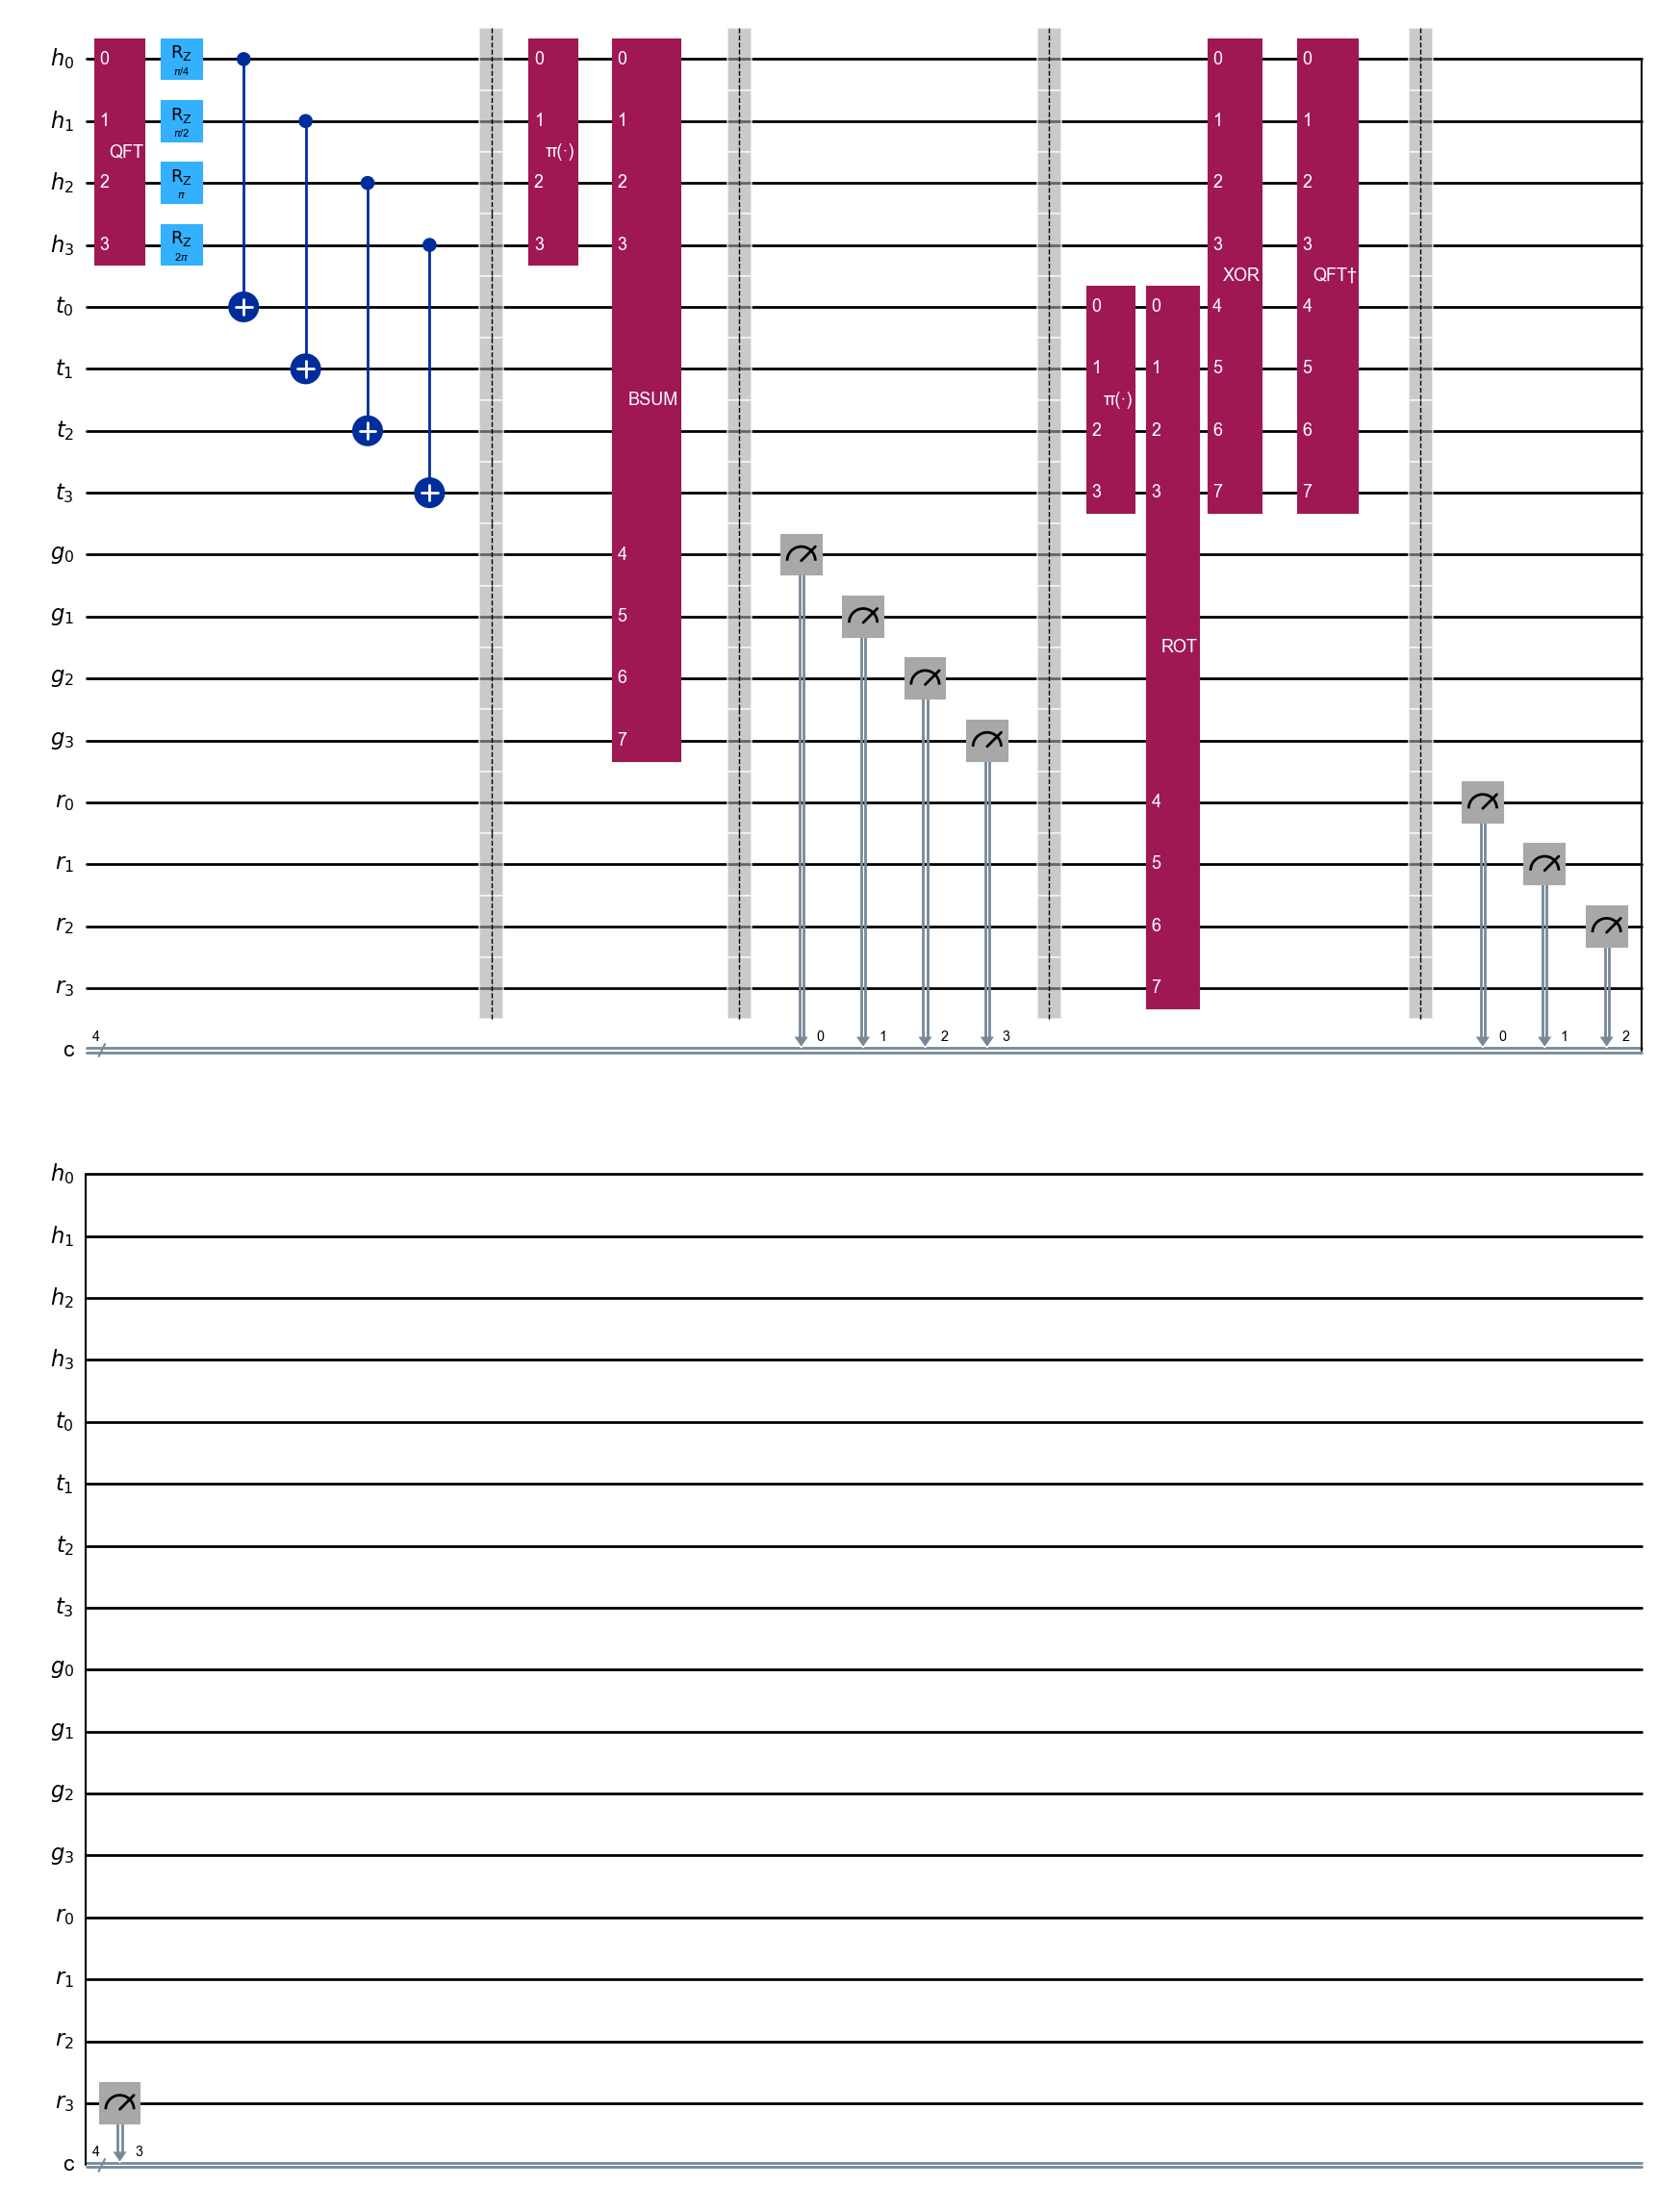

In [20]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
from qiskit.circuit import Gate
import numpy as np

# -------------------------------------------------------
# 1. Define registers
# -------------------------------------------------------
h = QuantumRegister(4, 'h')
t = QuantumRegister(4, 't')
g = QuantumRegister(4, 'g')
r = QuantumRegister(4, 'r')
c = ClassicalRegister(4, 'c')

qc = QuantumCircuit(h, t, g, r, c)


# -------------------------------------------------------
# 2. Define placeholder custom gates
#    (You can replace these later with actual circuits)
# -------------------------------------------------------

def placeholder_gate(name, num_qubits):
    return Gate(name, num_qubits, [])

BSUM = placeholder_gate("BSUM", 8)    # acts on h + t (example)
ROT  = placeholder_gate("ROT", 8)
XOR  = placeholder_gate("XOR", 8)
PI   = placeholder_gate("π(·)", 4)      # π(·) permutation
QFT_dag = QFT(8, do_swaps=True).inverse()
# QFT_dag = placeholder_gate("QFT†", 8)


# Convert to instruction so we can relabel it
QFT_dag = QFT_dag.to_instruction()
QFT_dag.name = "QFT†"        # label appearing in circuit
QFT_dag.label = "QFT†"       # optional; reinforces display


# -------------------------------------------------------
# 3. QFT block on h-register
# -------------------------------------------------------
qc.append(QFT(4, do_swaps=True), h[:])

# Add Rz rotations (your diagram: π/4, π/2, π, 2π)
qc.rz(np.pi/4, h[0])
qc.rz(np.pi/2, h[1])
qc.rz(np.pi,   h[2])
qc.rz(2*np.pi, h[3])

# -------------------------------------------------------
# 4. CNOT cascade h → t (matching the picture)
# -------------------------------------------------------
qc.cx(h[0], t[0])
qc.cx(h[1], t[1])
qc.cx(h[2], t[2])
qc.cx(h[3], t[3])

qc.barrier()


# -------------------------------------------------------
# 5. π(·) block
# -------------------------------------------------------
qc.append(PI, h[:])

# -------------------------------------------------------
# 6. BSUM block (takes h||t)
# -------------------------------------------------------
qc.append(BSUM, h[:] + g[:])

qc.barrier()

# -------------------------------------------------------
# 7. Mid-circuit measurements (on g0–g3)
# -------------------------------------------------------
qc.measure(g[0], c[0])
qc.measure(g[1], c[1])
qc.measure(g[2], c[2])
qc.measure(g[3], c[3])

qc.barrier()

# -------------------------------------------------------
# 8. π(·) → ROT → XOR → QFT† sequence
# -------------------------------------------------------
combined_qft_dag = h[:] + t[:]

qc.append(PI, t[:])
qc.append(ROT, t[:] + r[:])
qc.append(XOR, combined_qft_dag[:])
qc.append(QFT_dag, combined_qft_dag[:])

qc.barrier()

# -------------------------------------------------------
# 9. Final measurements (r-register)
# -------------------------------------------------------
qc.measure(r[0], c[0])
qc.measure(r[1], c[1])
qc.measure(r[2], c[2])
qc.measure(r[3], c[3])


# -------------------------------------------------------
# Display the circuit
# -------------------------------------------------------
qc.draw("mpl")


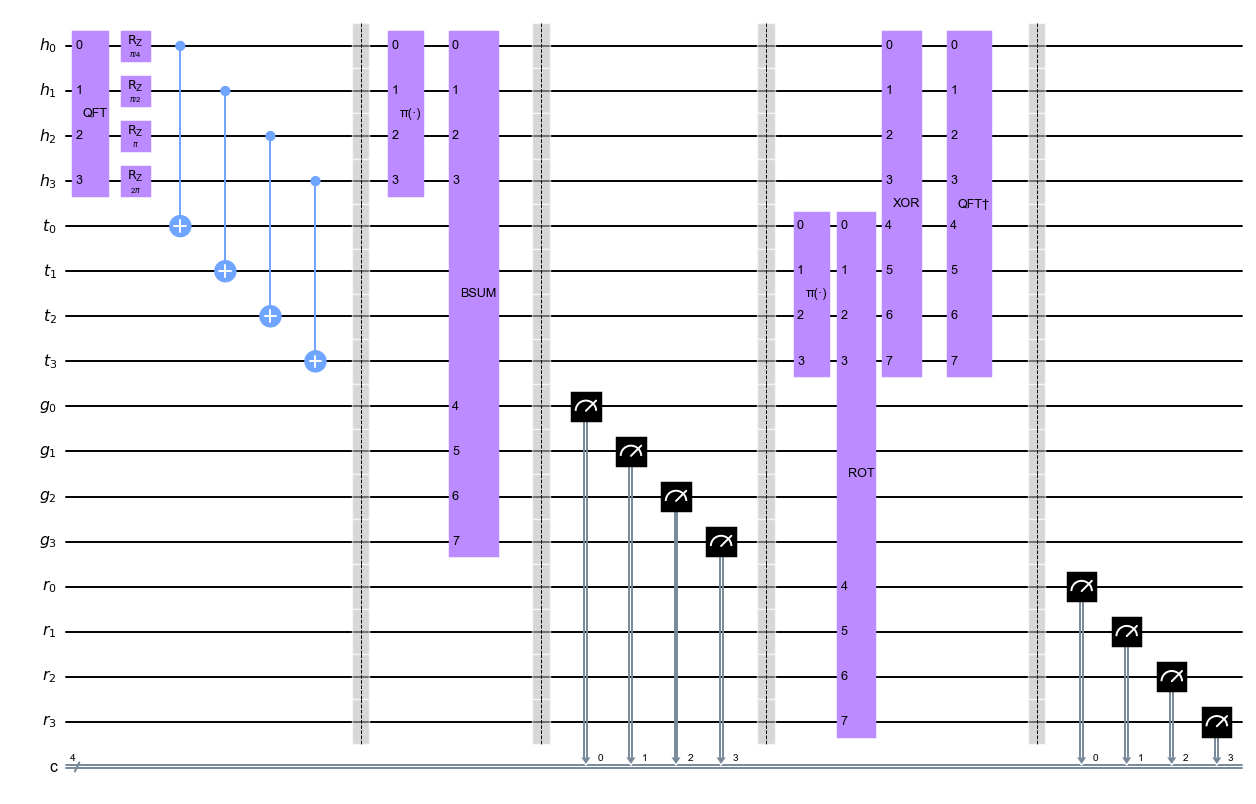

In [21]:
qc.draw('mpl', style='clifford', scale=0.7, fold=-1)

### analysis

#### TOTAL GATE COUNT (symbolic)
Two-qubit gates = 6 (QFT4) + 4 (CX) + G_π(4) + G_BSUM(8) + G_π(4) + G_ROT(8) + G_XOR(8) + 28 (QFT†8)
= 38 + 2·G_π(4) + G_BSUM(8) + G_ROT(8) + G_XOR(8)

Single-qubit gates = 4 (Rz) + 8 (QFT† Hadamards) = 12
TOTAL DEPTH (symbolic)
Depth = 4 (QFT4) + 1 (CX) + D_π(4) + D_BSUM(8) + 1 (meas.)
max(D_π(4), D_ROT(8), D_XOR(8), 8) + 1 (meas.)
≤ 4 + 1 + D_π(4) + D_BSUM(8) + 1 + max(D_π(4), D_ROT(8), D_XOR(8), 8) + 1
Scaling when registers grow to n qubits

If we keep the same structure but let each register contain
k = n/4 qubits, then every 4-qubit QFT becomes a k-qubit QFT,
every 8-qubit black box becomes a 2k-qubit black box, and the
dominant asymptotic cost is
QFT(k) and QFT†(2k) : Θ(k²) = Θ(n²) two-qubit gates
Black-box layers    : Θ((2k)²) = Θ(n²) two-qubit gates

# Overall Complexity

Let \(n\) be the number of qubits per register.

| Resource | Complexity |
|----------|---------|
| **Gate Count (Time)** | Θ(n²) |
| **Circuit Depth** | Θ(n)) |
| **Qubit Usage (Space)** | Θ(n) |
| **Classical Bits** | Θ(n) |

## Dominant Cost

The complexity is dominated by:
- The QFT on \(n\) qubits, and
- The inverse QFT on \(2n\) qubits,

both contributing Θ(n²) gates.

## Final Result

\[
\boxed{
\text{Time} = Θ(n²), \quad
\text{Depth} = Θ(n), \quad
\text{Space} = Θ(n)
}
